In [2]:
import h5py
import numpy as np
import pandas as pd
import os
import pandas as pd
import seaborn as sn
import torch
import torchvision.models as models
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from IPython.core.display import display
from collections.abc import Mapping
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split, TensorDataset
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import CSVLogger
import torchmetrics
from torchvision.transforms import ToTensor
import astropy.units as u
import astropy.coordinates as coord

import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')
from scipy import stats

/tmp/ipykernel_81610/1817125433.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


In [2]:
#User Input
sim = 'DR3_lsr012' #input("DR2 or DR3: ")
dim = '6D_cyl' #input("Input how many dimensions are needed: ")
galaxy = 'm12f_lsr0' #input("Use m12i or m12f data: ")
transfer = True #bool(input("Transfer learning (True or False): "))
if transfer == True:
    transfer_galaxy = 'm12i' #i nput("Which galaxy parameters for transfer learning: ")

# Training data
if dim == '4D':
    x_keys = ['ra', 'dec', 'pmra', 'pmdec']
elif dim == '5D':
    x_keys = ['ra', 'dec', 'pmra', 'pmdec', 'parallax']
elif dim == '6D':
    x_keys = ['ra', 'dec', 'pmra', 'pmdec', 'parallax', 'radial_velocity']
elif dim == '7D':
    x_keys = ['ra', 'dec', 'pmra', 'pmdec', 'parallax', 'radial_velocity', 'feh']
elif dim == '9D':
    x_keys = ['ra', 'dec', 'pmra', 'pmdec', 'parallax', 'radial_velocity', 'Jr', 'Jphi', 'Jz']
elif dim == '10D':
    x_keys = ['ra', 'dec', 'pmra', 'pmdec', 'parallax', 'radial_velocity', 'Jr', 'Jphi', 'Jz', 'feh']
elif dim == '6D_cyl':
    x_keys = ['ra', 'dec', 'pmra', 'pmdec', 'parallax', 'radial_velocity']
elif dim == '6D_gal':
    x_keys = ['ra', 'dec', 'pmra', 'pmdec', 'parallax', 'radial_velocity']
    
y_key = 'is_accreted'

# Directories
path = '/ocean/projects/phy210068p/hsu1/Ananke_datasets_training/AnankeDR3_data_reduced_m12f_lsr0.hdf5'
# path = '/ocean/projects/phy210068p/hsu1/Ananke_datasets_training/GaiaDR3_data_reduced.hdf5'
out_dir = '/ocean/projects/phy210068p/hsu1/Training_results/' + sim + '/' + galaxy + '/' + dim
roc_title = sim + '_' + galaxy + '_' + dim

# Parameters
learning_rate = 1e-3
batch_size = 1024
roc_path = '/ocean/projects/phy210068p/hsu1/Training_results/' + sim + '/' + galaxy + '/roc_parameters.hdf5'
training_score_path = '/ocean/projects/phy210068p/hsu1/Training_results/' + sim + '/' + galaxy + '/' + dim + '/training_score.hdf5'

if transfer == True:
    transfer_checkpoint = '/ocean/projects/phy210068p/hsu1/Training_results/' + sim +'/'+ transfer_galaxy +'/'+ dim + '/training_logs/version_0/checkpoints/last.ckpt'

train_parameter_file = out_dir + '/training_parameters.hdf5'
train_log = out_dir + '/training_logs'
checkpoint = train_log + '/version_0/checkpoints/last.ckpt'

In [3]:
data = []
f = h5py.File(path, 'r')

for i in x_keys:
    data.append(f[i][:])
y = f[y_key][:]

# Getting rid of nan values
x = []
if 'Jr' in x_keys:
    Jr = f['Jr'][:]
    mask = (~np.isnan(Jr))
    for i in range(len(x_keys)):
        new = data[i][:][mask]
        x.append(new)
    y = y[mask]
elif 'radial_velocity' in x_keys:
    rv = f['radial_velocity'][:]
    mask = (~np.isnan(rv))
    for i in range(len(x_keys)):
        new = data[i][:][mask]
        x.append(new)
    y = y[mask]
else:
    x = data

ra = x[0] * u.deg
dec = x[1] * u.deg
pmra = x[2] * u.mas / u.yr
pmdec = x[3] * u.mas / u.yr
parallax = x[4] * u.mas
rv = x[5] * u.km / u.s

dist = coord.Distance(parallax=parallax, allow_negative=True)

# Coord transformation
icrs = coord.ICRS(
    ra=ra, dec=dec, distance=dist, pm_ra_cosdec=pmra, pm_dec=pmdec, radial_velocity=rv)
icrs.representation_type = 'cylindrical'

rho_cyl = icrs.rho.to_value(u.pc)
phi_cyl = icrs.phi.to_value(u.deg)
z_cyl = icrs.z.to_value(u.pc)
vrho_cyl = icrs.d_rho.to_value(u.mas * u.pc / (u.rad * u.yr))
vphi_cyl = icrs.d_phi.to_value(u.mas / u.yr)
vz_cyl = icrs.d_z.to_value(u.mas * u.pc / (u.rad * u.yr))

x = []
x.append(rho_cyl)
x.append(phi_cyl)
x.append(z_cyl)
x.append(vrho_cyl)
x.append(vphi_cyl)
x.append(vz_cyl)

x = np.vstack(x).T
f.close()

with h5py.File(train_parameter_file, 'r') as f:
    shuffle = f['shuffle'][:]
x_save = x[shuffle]
y_save = y[shuffle]

x = x[shuffle]
y = y[shuffle]

n_train = int(0.9 *len(x))
n_val = len(x)-n_train
train_x, val_x = x[:n_train], x[n_train: n_train+n_val]
train_y, val_y = y[:n_train], y[n_train: n_train+n_val]

ny1 = np.sum(train_y==1)
ny0 = np.sum(train_y==0)
ny = ny1 + ny0
w1 = ny/ny1
w0 = ny/ny0
weight = torch.tensor([w0, w1], dtype=torch.float32)
mean_train_x = np.mean(train_x, axis = 0)
stdv_train_x = np.std(train_x, axis = 0)
train_x = (train_x - mean_train_x) / stdv_train_x
val_x = (val_x - mean_train_x) / stdv_train_x
train_x = torch.tensor(train_x, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.long)
val_x = torch.tensor(val_x, dtype=torch.float32)
val_y = torch.tensor(val_y, dtype=torch.long)

train_dataset = TensorDataset(train_x, train_y)
val_dataset = TensorDataset(val_x, val_y)
train_loader = DataLoader(train_dataset, batch_size = batch_size)
val_loader = DataLoader(val_dataset, batch_size = batch_size)

In [4]:
class Model(LightningModule):
                
    def __init__(self, weight, mean_train_x, stdv_train_x, transfer):
        super().__init__()
        self.save_hyperparameters()
        self.l1 = torch.nn.Linear(len(x_keys), 100) 
        self.l2 = torch.nn.Linear(100, 50)
        self.l3 = torch.nn.Linear(50, 2)
        
        self.train_acc = torchmetrics.Accuracy()
        self.valid_acc = torchmetrics.Accuracy()
        self.weight = weight
        self.mean_train_x = mean_train_x
        self.stdv_train_x = stdv_train_x
        if transfer == True:
            self.feature_extractor = Model.load_from_checkpoint(transfer_checkpoint, transfer=False)
            self.feature_extractor.freeze()
    
    def forward(self, x):
        x_out = self.l1(x)
        x_out = torch.relu(x_out)
        x_out = self.l2(x_out)
        x_out = torch.relu(x_out)
        x_out = self.l3(x_out)
        return x_out
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=learning_rate)
    
    def training_step(self, batch, batch_nb):
        train_x, train_y = batch 
        preds = self(train_x)
        loss = F.cross_entropy(preds, train_y, weight = self.weight.to(self.device))
        self.train_acc(preds, train_y)
        self.log('train_loss', loss)
        self.log('train_acc', self.train_acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_nb):
        val_x, val_y = batch
        preds = self(val_x)
        loss = F.cross_entropy(preds, val_y, weight=self.weight.to(self.device))
        self.valid_acc(preds, val_y)
        self.log('val_loss', loss)
        self.log('valid_acc', self.valid_acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss

In [5]:
# if transfer == True:
#     model = Model(weight, mean_train_x, stdv_train_x, transfer=True)
# else:
#     model = Model(weight, mean_train_x, stdv_train_x, transfer=False)
# model = Model.load_from_checkpoint(checkpoint)
# mean = model.mean_train_x
# stdv = model.stdv_train_x
# weight = model.weight

# n_test = n_val
# test_x = x[n_train: n_train+n_test]
# test_y = y[n_train: n_train+n_test]

# test_x = (test_x - mean) / stdv

# test_x = torch.tensor(test_x, dtype=torch.float32)
# test_y = torch.tensor(test_y, dtype=torch.long)

# test_dataset = list(zip(test_x, test_y))
# test_loader = DataLoader(test_dataset, batch_size = batch_size)

In [5]:
if transfer == True:
    model = Model(weight, mean_train_x, stdv_train_x, transfer=True)
else:
    model = Model(weight, mean_train_x, stdv_train_x, transfer=False)
model = Model.load_from_checkpoint(checkpoint)
mean = model.mean_train_x
stdv = model.stdv_train_x
weight = model.weight

test_x = (x - mean) / stdv

test_x = torch.tensor(test_x, dtype=torch.float32)
test_y = torch.tensor(y, dtype=torch.long)

test_dataset = list(zip(test_x, test_y))
test_loader = DataLoader(test_dataset, batch_size = batch_size)

In [6]:
predict = []
target = []
x_final = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        x, y = batch
        yhat = model(x)
        predict.append(yhat.cpu().numpy())
        target.append(y.cpu().numpy())
        x_final.append(x.cpu().numpy())
predict = np.concatenate(predict)
target = np.concatenate(target)
x_final = np.concatenate(x_final)

score = np.exp(predict[:,1])/(np.exp(predict[:,0])+np.exp(predict[:,1]))
target_true_mask = (target==True)
target_false_mask = (target==False)

In [21]:
score_path = '/ocean/projects/phy210068p/hsu1/Training_results/DR3_lsr012/m12f_lsr012/6D_cyl/training_score.hdf5'
with h5py.File(score_path, 'r') as f:
    print(f.keys)
    x_final = f['x_final'][:]
    score = f['score'][:]
    target = f['target'][:]

<bound method MappingHDF5.keys of <HDF5 file "training_score.hdf5" (mode r)>>


In [22]:
x_final.shape

(78614384, 6)

In [23]:
vrho_dat = x_final[:, 3]
vphi_dat = x_final[:, 4]
vz_dat = x_final[:, 5]
vrho = (vrho_dat - np.min(vrho_dat)) / (np.max(vrho_dat) - np.min(vrho_dat))
vphi = (vphi_dat - np.min(vphi_dat)) / (np.max(vphi_dat) - np.min(vphi_dat))
vz = (vz_dat - np.min(vz_dat)) / (np.max(vz_dat) - np.min(vz_dat))
num_bin = 1000
thresholds = np.linspace(0.01, 0.99, 100)
X2 = []
for thres in thresholds:
    score_1 = score>thres

    vrho_true = vrho[target==True]
    vrho_true_bin, _ = np.histogram(vrho_true, bins= np.linspace(0, 1, num_bin), density=True)

    vrho_pred = vrho[score_1==True]
    vrho_pred_bin, _ =  np.histogram(vrho_pred, bins= np.linspace(0, 1, num_bin), density=True)

    vrho_X2 = np.sum((vrho_true_bin - vrho_pred_bin)**2)

    vphi_true = vphi[target==True]
    vphi_true_bin, _ =  np.histogram(vphi_true, bins= np.linspace(0, 1, num_bin), density=True)

    vphi_pred = vphi[score_1==True]
    vphi_pred_bin, _ =  np.histogram(vphi_pred, bins= np.linspace(0, 1, num_bin), density=True)

    vphi_X2 = np.sum((vphi_true_bin - vphi_pred_bin)**2)

    vz_true = vz[target==True]
    vz_true_bin, _ = np.histogram(vz_true, bins= np.linspace(0, 1, num_bin), density=True)

    vz_pred = vz[score_1==True]
    vz_pred_bin, _ = np.histogram(vz_pred, bins= np.linspace(0, 1, num_bin), density=True)

    vz_X2 = np.sum((vz_true_bin - vz_pred_bin)**2)

    X2.append(vrho_X2 + vphi_X2 + vz_X2)

In [24]:
vrho.shape

(78614384,)

In [25]:
score_cut = thresholds[X2/min(X2) == np.min(X2/min(X2))]

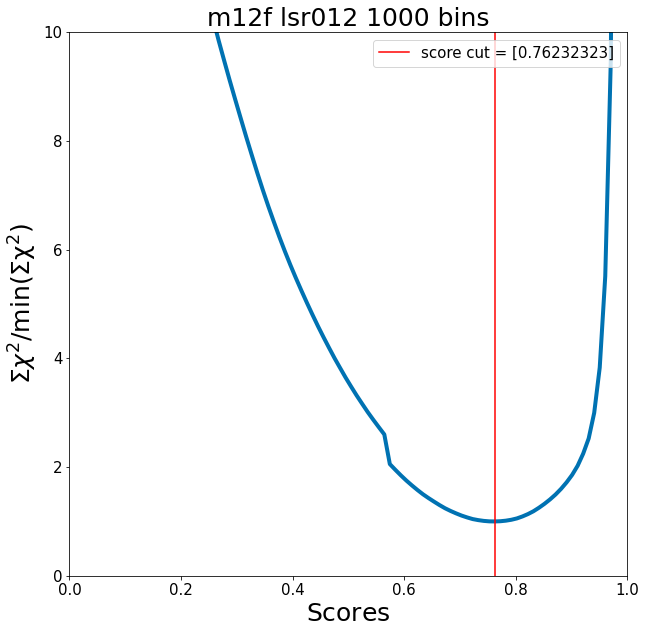

In [26]:
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.plot(thresholds, X2/min(X2), linewidth=4)
ax.axvline(score_cut, color='r', label=f'score cut = {score_cut}')
ax.set_title(f'm12f lsr012 {num_bin} bins', fontsize=25)
ax.set_xlabel(r'$\rm{Scores}$', fontsize=25)
ax.set_ylabel(r'$\Sigma \chi^2 / \rm{min}(\Sigma \chi^2)$', fontsize=25)
ax.tick_params(axis='both', labelsize=15)
ax.set_ylim(0, 10)
ax.set_xlim(0, 1)
ax.tick_params(axis='both', labelsize=15)
ax.legend(loc='upper right', fontsize=15)

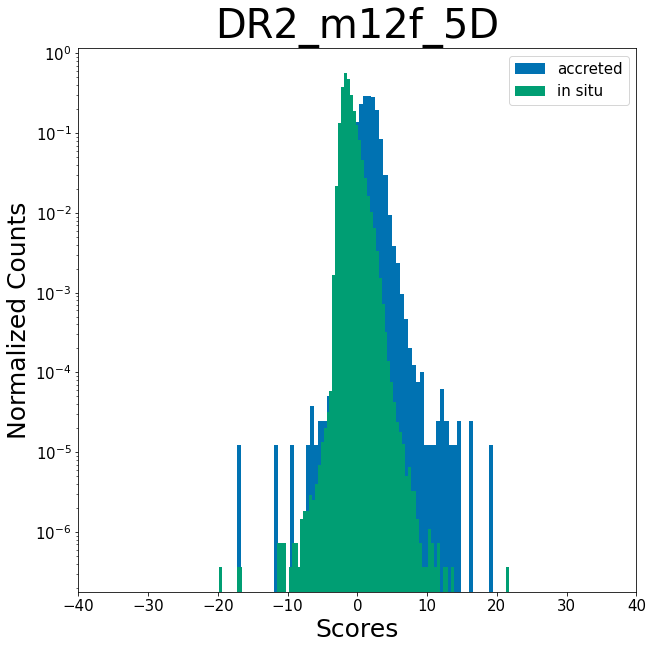

In [12]:
fig, ax = plt.subplots(1, figsize=(10, 10))

ax.hist(score_a, bins=100, density=True, label='accreted')
ax.hist(score_i, bins=100, density=True, label='in situ')
ax.set_title(roc_title, fontsize=40)
ax.set_xlabel('Scores', fontsize=25)
ax.set_ylabel('Normalized Counts', fontsize=25)
ax.tick_params(axis='both', labelsize=15)
plt.xlim([-40,40])
plt.yscale('log')
# plt.ylim([0,25])
ax.legend(loc='upper right', fontsize=15)

In [ ]:
#    vrho_true = vrho[target==True]
#     vrho_true_bin_stat = stats.binned_statistic(np.linspace(np.min(vrho_true), np.max(vrho_true), len(vrho_true)), vrho_true
#                                            , 'median', bins=num_bin)
#     vrho_true_bin = vrho_true_bin_stat.statistic

#     vrho_pred = vrho[score_1==True]
#     vrho_pred_bin_stat = stats.binned_statistic(np.linspace(np.min(vrho_pred), np.max(vrho_pred), len(vrho_pred)), vrho_pred
#                                            , 'median', bins=num_bin)
#     vrho_pred_bin = vrho_true_bin_stat.statistic 

#     vrho_X2 = np.sum((vrho_true_bin - vrho_pred_bin)**2)

#     vphi_true = vphi[target==True]
#     vphi_true_bin_stat = stats.binned_statistic(np.linspace(np.min(vphi_true), np.max(vphi_true), len(vphi_true)), vphi_true
#                                            , 'median', bins=num_bin)
#     vphi_true_bin = vphi_true_bin_stat.statistic 

#     vphi_pred = vphi[score_1==True]
#     vphi_pred_bin_stat = stats.binned_statistic(np.linspace(np.min(vphi_pred), np.max(vphi_pred), len(vphi_pred)), vphi_pred
#                                            , 'median', bins=num_bin)
#     vphi_pred_bin = vrho_pred_bin_stat.statistic 

#     vphi_X2 = np.sum((vphi_true_bin - vphi_pred_bin)**2)

#     vz_true = vz[target==True]
#     vz_true_bin_stat = stats.binned_statistic(np.linspace(np.min(vz_true), np.max(vz_true), len(vz_true)), vz_true
#                                            , 'median', bins=num_bin)
#     vz_true_bin = vz_true_bin_stat.statistic 

#     vz_pred = vz[score_1==True]
#     vz_pred_bin_stat = stats.binned_statistic(np.linspace(np.min(vz_pred), np.max(vz_pred), len(vz_pred)), vz_pred
#                                            , 'median', bins=num_bin)
#     vz_pred_bin = vz_pred_bin_stat.statistic 

#     vz_X2 = np.sum((vz_true_bin - vz_pred_bin)**2)

In [ ]:
    # score_1 = score>thres

    # vrho_true = vrho[target==True]
    # vrho_true_bin = np.histogram(vrho_true, bins=num_bin)

    # vrho_pred = vrho[score_1==True]
    # vrho_pred_bin =  np.histogram(vrho_pred, bins=num_bin)

    # vrho_X2 = np.sum((vrho_true_bin - vrho_pred_bin)**2)

    # vphi_true = vphi[target==True]
    # vphi_true_bin =  np.histogram(vphi_true, bins=num_bin)

    # vphi_pred = vphi[score_1==True]
    # vphi_pred_bin =  np.histogram(vphi_pred, bins=num_bin)

    # vphi_X2 = np.sum((vphi_true_bin - vphi_pred_bin)**2)

    # vz_true = vz[target==True]
    # vz_true_bin = np.histogram(vz_true, bins=num_bin)

    # vz_pred = vz[score_1==True]
    # vz_pred_bin = np.histogram(vz_pred, bins=num_bin)

    # vz_X2 = np.sum((vz_true_bin - vz_pred_bin)**2)

    # X2.append(vrho_X2 + vphi_X2 + vz_X2)